Goal
==
We are about to train a *sequence-to-sequence model* to predict a paragraph of Gustave Flaubert's *Madame Bovary* given the preceding paragraph.
The model (at least in its first version) does not use words as units of text but characters.

*   The encoder part, based on a bidirectional LSTM, reads an input paragraph and turns it into a set of tensors that serves as initial state for the decoder part.
*   The decoder part is based on an (unidirectional) LSTM. The state of the LSTM is used to compute a probability distribution over the alphabet (including space and punctuation marks) and is updated each time a character is predicted by the LSTM reading this character's embedding.
*   The goal is to get the best model. It is part of the job to define what this means. It is also part of the job to explain me how you get your best model.

Loading PyTorch is important.
==

In [ ]:
# Imports PyTorch.
import torch

Downloading the dataset
==
The dataset we are going to use is there: https://www.gutenberg.org/cache/epub/14155/pg14155.txt

We have to pre-process it a little bit in order to remove everything that is not part of the text and to split the actual text into paragraphs.

In [ ]:
use_toy_dataset = False # If True, a toy dataset (see below) is used, instead of the "real" one.

In this place we set `use_toy_dataset = False` because preliminary experimental results show that the model already exhibits good performance on smaller datasets (see block's model prediction results below), which suggests that our model design is capable of meeting the needs of the target task. However, due to the limitation of the dataset size, the model may not be able to fully learn more complex or rare patterns, so we can further optimize the model by using larger datasets.

In [ ]:
# Downloads the dataset.
import urllib

tmp = urllib.request.urlretrieve("https://www.gutenberg.org/cache/epub/14155/pg14155.txt")
filename = tmp[0]
print(filename)

/tmp/tmpetb4icyd


In [ ]:
# Prints the first 200 lines in the file with their line number.
# This shows that we have a little bit of preprocessing to do in order to clean the data.
with open(filename) as f:
  for i in range(200):
    print(f"[{i}] {f.readline()}", end='')

[0] ﻿The Project Gutenberg eBook of Madame Bovary
[1]     
[2] This ebook is for the use of anyone anywhere in the United States and
[3] most other parts of the world at no cost and with almost no restrictions
[4] whatsoever. You may copy it, give it away or re-use it under the terms
[5] of the Project Gutenberg License included with this ebook or online
[6] at www.gutenberg.org. If you are not located in the United States,
[7] you will have to check the laws of the country where you are located
[8] before using this eBook.
[9] 
[10] Title: Madame Bovary
[11] 
[12] Author: Gustave Flaubert
[13] 
[14] Release date: November 26, 2004 [eBook #14155]
[15]                 Most recently updated: December 18, 2020
[16] 
[17] Language: French
[18] 
[19] Credits: Produced by Ebooks libres et gratuits at http://www.ebooksgratuits.com
[20] 
[21] 
[22] *** START OF THE PROJECT GUTENBERG EBOOK MADAME BOVARY ***
[23] 
[24] 
[25] 
[26] 
[27] Produced by Ebooks libres et gratuits at http://www.ebooksg

In [ ]:
import re # Regular expression library
roman_regex = re.compile('^M{0,4}(CM|CD|D?C{0,3})(XC|XL|L?X{0,3})(IX|IV|V?I{0,3})$') # This regular expression matches Roman numerals but also the empty string.

EOP = '\n' # The end-of-line character will be used to mark the end of paragraphs.

with open(filename) as f:
  # We want to skip everything before the actual text of the novel.
  # The line "PREMIÈRE PARTIE" appears twice: in the table of content and then at the start of the first part of the actual text.
  # The following lines discard everything up to this second occurence (included).
  skip = 2
  while(skip > 0):
    line = f.readline().strip()
    if(line == "PREMIÈRE PARTIE"): skip -= 1;

  paragraphs = [] # Note that each dialog line will be considered a separate paragraph.
  paragraph_buffer = [] # List[str]; each element corresponds to a line in the original text file + an additonal space if necessary.
  while(True):
    line = f.readline().strip()
    if("END OF THE PROJECT GUTENBERG EBOOK MADAME BOVARY" in line): break # End of the actual text.

    if(line == ""): # We've reached the end of a paragraph.
      if(len(paragraph_buffer) > 0):
        paragraph_buffer.append(EOP) # End of the paragraph.

        paragraph = "".join(paragraph_buffer) # The different lines that make up the paragraph are joined into a single string.
        paragraphs.append(paragraph)
        paragraph_buffer = []
      continue

    if(roman_regex.match(line)): continue # Ignores the lines that indicate the beginning of a chapter.
    if(line.endswith(" PARTIE")): continue # Ignores the lines that indicate the beginning of a part.

    if((len(paragraph_buffer) > 0) and (paragraph_buffer[-1][-1] != '-')): paragraph_buffer.append(' ') # Adds a space between consecutive lines except when the first one ends with "-" (e.g. if the word "pomme-de-terre" is split with "pomme-de-" at the end of a line and "terre" at the beginning of the next, we do not want to join the two lines with a space).
    paragraph_buffer.append(line)

print(f"{len(paragraphs)} paragraphs read.")
for i in range(3): print(paragraphs[i], end='')

2995 paragraphs read.
Nous étions à l'Étude, quand le Proviseur entra, suivi d'un nouveau habillé en bourgeois et d'un garçon de classe qui portait un grand pupitre. Ceux qui dormaient se réveillèrent, et chacun se leva comme surpris dans son travail.
Le Proviseur nous fit signe de nous rasseoir; puis, se tournant vers le maître d'études:
-- Monsieur Roger, lui dit-il à demi-voix, voici un élève que je vous recommande, il entre en cinquième. Si son travail et sa conduite sont méritoires, il passera dans les grands, où l'appelle son âge.


Here, we define a toy dataset on which your model, if correctly implemented, should be able to learn more easily.

In [ ]:
if(use_toy_dataset):
  paragraphs = []

  import random, string
  characters = list(string.ascii_lowercase + string.ascii_lowercase.upper() + "_-/\'[]()")
  random.shuffle(characters)
  k = random.randint(1, 10)
  a = "a"
  paragraph = (a * k)
  for _ in range(100):
    random.shuffle(characters)
    for a in characters:
      k = random.randint(1, 16)
      paragraph += f"? Now, please write {k} {a}.{EOP}"
      paragraphs.append(paragraph)
      paragraph = (a * k)
  print(f"{len(paragraphs)} paragraphs generated.")

  print(paragraphs[:10])

Since we are using a larger dataset, we also split the dataset at `rate=0.8` into `80% training set` and `20% dev set`, where the training set is used to learn the parameters of the model and the dev set is used to evaluate the generalization ability of the model. The advantage of this is that the dev set is data that the model has not seen during the training process, and by monitoring the model's performance on the dev set, the occurrence of **overfitting** can be detected and the training can be terminated in a timely manner through **early stopping**. In addition, the dev set can be used as a basis for **hyper-parameter tuning**, e.g., adjusting the learning rate, batch size, etc.

In [ ]:
# separate datasets into train and dev

n = len(paragraphs)
rate = 0.8
paragraphs, paragraphs_dev = paragraphs[:int(n*rate)], paragraphs[int(n*rate):]
print(f"{len(paragraphs)} paragraphs in the training set.")
print(f"{len(paragraphs_dev)} paragraphs in the development set.")

2396 paragraphs in the training set.
599 paragraphs in the development set.


In [ ]:
import collections
import numpy as np

# Computes the frequency of all characters in the dataset.
char_counts = collections.defaultdict(int)
for paragraph in paragraphs:
  for char in paragraph: char_counts[char] += 1

print(f"{len(char_counts)} different characters found in the dataset.")
print(sorted(char_counts.items(), key=(lambda x: x[1]), reverse=True)) # Shows each character with its frequency, in decreasing frequency order.

94 different characters found in the dataset.
[(' ', 93470), ('e', 65537), ('a', 38453), ('s', 36953), ('t', 33017), ('i', 32454), ('n', 29943), ('r', 29188), ('l', 28739), ('u', 28107), ('o', 23359), ('d', 16560), ('c', 12613), ('m', 12507), ('p', 11738), (',', 10667), ('v', 7238), ('é', 7020), ("'", 6278), ('.', 5130), ('q', 4724), ('b', 4717), ('f', 4583), ('h', 4516), ('g', 4036), ('-', 3519), ('\n', 2396), ('à', 2360), ('x', 1731), ('j', 1491), ('y', 1400), ('è', 1383), ('E', 1239), (';', 1204), ('!', 1188), ('ê', 1011), ('L', 835), ('C', 796), ('M', 630), ('I', 590), ('z', 575), ('?', 455), ('A', 451), ('ç', 391), (':', 378), ('B', 356), ('â', 345), ('P', 320), ('î', 283), ('R', 275), ('D', 269), ('S', 262), ('ù', 253), ('ô', 249), ('O', 243), ('Q', 209), ('û', 202), ('H', 198), ('J', 182), ('V', 158), ('T', 157), ('N', 132), ('U', 99), ('«', 99), ('»', 91), ('À', 72), ('Y', 69), ('F', 60), ('G', 52), ('(', 44), (')', 44), ('_', 40), ('ï', 33), ('É', 21), ('1', 16), ('k', 15), ('

In [ ]:
# char2id
char_vocabulary = {char : i for i, (char, _) in enumerate(char_counts.items())}
# id2char
id_to_char = list(char_vocabulary.keys())

In [ ]:
EOP_id = char_vocabulary[EOP] # Id for the end-of-paragraph symbol
padding_id = EOP_id + 1 # Pseudo-id for the "padding symbol" (which in fact does not exist)

print(char_vocabulary)
print(id_to_char)
print(f"EOP_id = {EOP_id}")

def test_consistent(char_vocabulary, id_to_char):
    for char, id in char_vocabulary.items():
        assert char == id_to_char[id]
    for id, char in enumerate(id_to_char):
        assert id == char_vocabulary[char]
    print("Test successfully, the implementations of 'char_vocabulary' and 'id_to_char' are consistent.")

test_consistent(char_vocabulary, id_to_char)

{'N': 0, 'o': 1, 'u': 2, 's': 3, ' ': 4, 'é': 5, 't': 6, 'i': 7, 'n': 8, 'à': 9, 'l': 10, "'": 11, 'É': 12, 'd': 13, 'e': 14, ',': 15, 'q': 16, 'a': 17, 'P': 18, 'r': 19, 'v': 20, 'h': 21, 'b': 22, 'g': 23, 'ç': 24, 'c': 25, 'p': 26, '.': 27, 'C': 28, 'x': 29, 'm': 30, 'è': 31, '\n': 32, 'L': 33, 'f': 34, ';': 35, 'î': 36, ':': 37, '-': 38, 'M': 39, 'R': 40, 'j': 41, 'S': 42, 'ù': 43, 'â': 44, 'z': 45, 'I': 46, 'Q': 47, 'û': 48, 'ê': 49, 'O': 50, 'y': 51, 'k': 52, 'ï': 53, 'E': 54, 'T': 55, 'U': 56, 'D': 57, '!': 58, '(': 59, ')': 60, 'B': 61, '?': 62, '_': 63, 'G': 64, '1': 65, '8': 66, '2': 67, 'A': 68, 'À': 69, 'H': 70, 'ô': 71, 'V': 72, 'Ê': 73, '«': 74, '»': 75, 'Y': 76, 'F': 77, 'J': 78, 'ë': 79, 'W': 80, 'X': 81, '0': 82, '5': 83, '7': 84, '9': 85, '6': 86, '3': 87, 'w': 88, 'Î': 89, 'Ç': 90, '4': 91, 'ü': 92, '°': 93}
['N', 'o', 'u', 's', ' ', 'é', 't', 'i', 'n', 'à', 'l', "'", 'É', 'd', 'e', ',', 'q', 'a', 'P', 'r', 'v', 'h', 'b', 'g', 'ç', 'c', 'p', '.', 'C', 'x', 'm', 'è', '

In [ ]:
# Turns a list of lists of ids into a list of strings.
# Do not forget that an occurrence of EOP means that the paragraph ends here.
# ids: list[int]
def ids_to_texts(ids):
  results = []
  for id in ids:
    chars = []
    for item in id:
      if item == EOP_id:
        break
      chars.append(id_to_char[item])
    results.append(''.join(chars))
  return results

In [ ]:
ps = ["Bonjour.", "Comment allez vous ?"]
ids = [[char_vocabulary[c] for c in p] for p in ps]
print(ids)
print(ids_to_texts(ids))
print(f"'ids_to_texts(ids) == ps' should be True: {ids_to_texts(ids) == ps}")

[[61, 1, 8, 41, 1, 2, 19, 27], [28, 1, 30, 30, 14, 8, 6, 4, 17, 10, 10, 14, 45, 4, 20, 1, 2, 3, 4, 62]]
['Bonjour.', 'Comment allez vous ?']
'ids_to_texts(ids) == ps' should be True: True


In [ ]:
ps = ["Bonjour.", "Comment allez vous ?"]
ids = [[char_vocabulary[c] for c in p] for p in ps]
ids[0].extend([EOP_id, padding_id, padding_id]) # With the end-of-paragraph token id and additional (padding-like) stuff for the first string.
print(ids)
print(ids_to_texts(ids))
print(f"'ids_to_texts(ids) == ps' should be True: {ids_to_texts(ids) == ps}") # If you have a problem here, remember that EOP indicates the end of the text (this might be related to your problem).

[[61, 1, 8, 41, 1, 2, 19, 27, 32, 33, 33], [28, 1, 30, 30, 14, 8, 6, 4, 17, 10, 10, 14, 45, 4, 20, 1, 2, 3, 4, 62]]
['Bonjour.', 'Comment allez vous ?']
'ids_to_texts(ids) == ps' should be True: True


Batch generator
==

In [ ]:
# Defines a class of objects that produce batches from the dataset.
# A training instance is composed of a pair of consecutive paragraphs. The goal will be to predict the second given the first.
# (Possible improvement: As is, ends of chapter are completely ignored: the last paragraph of a chapter and the first of the following chapter form a training instance. We might want to predict the end of the chapter instead, or simply remove these pairs from the dataset.)
class BatchGenerator:
  # paragraphs: list[str]
  # char_vocabulary: dict[str, int]
  def __init__(self, paragraphs, char_vocabulary):
    self.paragraphs = paragraphs
    self.char_vocabulary = char_vocabulary # Dictionary
    self.padding_idx = len(char_vocabulary)

  # Returns the number of training instances (i.e. of pairs of consecutive paragraphs).
  def length(self):
    return (len(self.paragraphs) - 1)

  # Returns a random training batch (composed of pairs of consecutive paragraphs).
  # batch_size: int
  # subset: int | None; if an integer, only a subset of the corpus is used. This can be useful when debugging the system.
  def get_batch(self, batch_size, subset=None):
    max_i = self.length() if(subset is None) else min(subset, self.length())
    paragraph_ids = np.random.randint(max_i, size=batch_size) # Randomly picks some paragraph ids.

    return self._ids_to_batch(paragraph_ids)

  # paragraph_ids: sequence of int·s
  def _ids_to_batch(self, paragraph_ids):
    firsts = [] # list[list[int]]; first paragraph of each pair
    seconds = [] # list[list[int]], second paragraph of each pair
    for paragraph_id in paragraph_ids:
      firsts.append([self.char_vocabulary[char] for char in self.paragraphs[paragraph_id]])
      seconds.append([self.char_vocabulary[char] for char in self.paragraphs[paragraph_id + 1]])

    # Padding
    self.pad(firsts)
    self.pad(seconds)

    firsts = torch.tensor(firsts, dtype=torch.long) # Conversion to a tensor
    seconds = torch.tensor(seconds, dtype=torch.long) # Conversion to a tensor

    return (firsts, seconds)

  # Pads a list of lists (i.e. adds fake word ids so that all sequences in the batch have the same length, so that we can use a matrix to represent them).
  # Works "in place".
  # sequences: list[list[int]]
  def pad(self, sequences):
    max_length = max([len(s) for s in sequences])
    for s in sequences: s.extend([self.padding_idx] * (max_length - len(s)))

  # Returns a generator of training batches for a full epoch. (Note that this function is not used in the training loop implemented below. `get_batch` is used instead.)
  # batch_size: int
  # subset: int | None; if an integer, only a subset of the corpus is used. This can be useful when debugging the system.
  def all_batches(self, batch_size, subset=None):
    max_i = self.length() if(subset is None) else min(subset, self.length())

    # Loop that generates all full batches (batches of size 'batch_size').
    i = 0
    while((i + batch_size) <= max_i):
      instance_ids = np.arange(i, (i + batch_size))
      yield self._ids_to_batch(instance_ids)
      i += batch_size

    # Possibly generates the last (not full) batch.
    if(i < max_i):
      instance_ids = np.arange(i, max_i)
      yield self._ids_to_batch(instance_ids)

  # Turns a list of arbitrary paragraphs into a prediction batch.
  # paragraphs: list[str]
  def turn_into_batch(self, paragraphs):
    firsts = [] # list[list[int]]
    for paragraph in paragraphs:
        tmp = [] # list[int]
        for char in paragraph:
          # Unknown characters are ignored (removed).
          if(char in self.char_vocabulary): tmp.append(self.char_vocabulary[char])

        if(tmp[-1] != EOP_id): tmp.append(EOP_id) # Adds an end-of-paragraph character if necessary.

        firsts.append(tmp)

    self.pad(firsts)
    return torch.tensor(firsts, dtype=torch.long)

batch_generator = BatchGenerator(paragraphs=paragraphs, char_vocabulary=char_vocabulary)
dev_batch_generator = BatchGenerator(paragraphs=paragraphs_dev, char_vocabulary=char_vocabulary)
print(f" {batch_generator.length()} examples for train")
print(f" {dev_batch_generator.length()} examples for dev")

 2395 examples for train
 598 examples for dev


We can see at the end of the previous code block that `batch_generator` is generated based on the training set (paragraphs_train) for training the model and `dev_batch_generator` is generated based on the dev set (paragraphs_dev) for model evaluation. Such operations provide the basis for later model optimization.

In [ ]:
(firsts, seconds) = batch_generator.get_batch(3)
print(ids_to_texts(firsts))
print(ids_to_texts(seconds))

["-- Une chose... grave, sérieuse. Eh! non, d'ailleurs, vous ne partirez pas, c'est impossible! Si vous saviez... Écoutez-moi... Vous ne m'avez donc pas compris? vous n'avez pas deviné?...", '-- Tantôt, par exemple, quand je suis venu chez vous...', "Justin ne répondait pas. L'apothicaire continuait:"]
['-- Cependant vous parlez bien, dit Emma.', '«À M. Bizet, de Quincampoix.»', "-- Qui t'a prié de venir? Tu importunes toujours monsieur et madame! Les mercredis, d'ailleurs, ta présence m'est plus indispensable. Il y a maintenant vingt personnes à la maison. J'ai tout quitté à cause de l'intérêt que je te porte. Allons, va-t'en! cours! attends-moi, et surveille les bocaux!"]


The model
==
For this model, we will not define a `forward` method, but two methods: `trainingLogits` and `predictionStrings`.

*    `trainingLogits` is used at training time, when each batch is split in two parts: input paragraphs and output paragraphs. This function outputs, for each output paragraph of the batch, a log-probability distribution (i.e. a vector of "logits") before each token and after the last one. These distributions depend on the encoding of the corresponding input paragraph. They will then be used to compute a loss value.
*    `predictionStrings` is used at prediction time, when each batch is only composed of input paragraphs. This function outputs, for each input paragraph, a string obtained by decoding the encoding of the paragraph and its probability according to the model.

In [ ]:
class Model(torch.nn.Module):
  # size_vocabulary: int; does not include a padding character, but does include the end-of-paragraph one.
  # EOP_id: int
  # embedding_dim: int
  # lstm_hidden_size: int
  # lstm_layers: int
  # device: str
  def __init__(self, size_vocabulary, EOP_id, embedding_dim, lstm_hidden_size, lstm_layers, device='cpu'):
    super().__init__()

    self.device = device

    self.EOP_id = EOP_id # At prediction time, this index is used to stop the generation at the end of the paragraph.

    #  (i) an embedding layer 'self.char_embeddings' with 'torch.nn.Embedding' for the characters, including an padding embedding;
    #  (ii) a bidirectional LSTM 'self.encoder_lstm' with a hidden size of 'lstm_hidden_size' and 'lstm_layers' layers (use batch_first=True);
    #  (iii) a unidirectional LSTM 'self.decoder_lstm' with a hidden size of 'lstm_hidden_size' and 'lstm_layers' layers (use batch_first=True);
    #  (iv) a network 'self.decoder_initialiser' meant to turn the final hidden and cell states of the encoder into the initial hidden and cell states of the decoder;
    #  (v) a network 'self.distribution_nn' meant to turn the hidden state of the decoder at each step into the logits of a probability distribution over the vocabulary. The logits of a probability distribution are simply the log-probabilities (you might want to use torch.nn.LogSoftmax).
    self.char_embeddings = torch.nn.Embedding(size_vocabulary+1, embedding_dim, padding_idx=size_vocabulary).to(device) # size_vocabulary +1 for the pad token
    self.encoder_lstm = torch.nn.LSTM(embedding_dim, lstm_hidden_size, lstm_layers, batch_first=True, bidirectional=True).to(device)
    self.decoder_lstm = torch.nn.LSTM(embedding_dim, lstm_hidden_size, lstm_layers, batch_first=True).to(device)
    self.decoder_initialiser = torch.nn.Sequential(
        torch.nn.Linear(lstm_hidden_size * 2, lstm_hidden_size),
        torch.nn.Tanh()
    ).to(device)
    self.distribution_nn = torch.nn.Sequential(
        torch.nn.Linear(lstm_hidden_size, size_vocabulary),
        torch.nn.LogSoftmax(dim=-1)
    ).to(device)

  # This function encodes the input paragraphs and turns them into initial states for the decoder. It is used both at training and prediction time.
  # 'in_paragraphs' is a matrix (batch size, max in length) of character ids (Integer).
  def initStates(self, in_paragraphs):
    batch_size = in_paragraphs.size(0)

    in_char_embeddings = self.char_embeddings(in_paragraphs) # Shape: (batch_size, max length, embedding size)
    in_lengths = (in_paragraphs != self.char_embeddings.padding_idx).sum(axis=1) # Shape: (batch_size)
    in_char_embeddings = torch.nn.utils.rnn.pack_padded_sequence(input=in_char_embeddings, lengths=in_lengths.cpu(), batch_first=True, enforce_sorted=False) # Enables the biLSTM to ignore padding elements.
    # The input paragraphs are encoded; the final hidden and cell states of the network will be used to initialise the decoder after a little transformation.
    _, (h_n, c_n) = self.encoder_lstm(in_char_embeddings) # 'h_n' and 'c_n' are both of shape (num_layers * 2, batch_size, hidden_size)

    # Concatenates the left-to-right and right-to-left final hidden states of the biLSTM.
    h_n = h_n.view(self.encoder_lstm.num_layers, 2, batch_size, self.encoder_lstm.hidden_size) # The second dimension (of size 2) of this tensor corresponds to left-to-right (0) and right-to-left (1).
    #print(h_n); print(h_n.shape)
    lr_h_n = h_n[:,0] # left-to-right; shape: (num_layers, batch_size, hidden_size)
    rl_h_n = h_n[:,1] # right-to-left; shape: (num_layers, batch_size, hidden_size)
    bi_h_n = torch.cat([lr_h_n, rl_h_n], axis=2) # Shape: (num_layers, batch_size, (2 * hidden_size))

    # Concatenates the left-to-right and right-to-left final cell states of the biLSTM.
    c_n = c_n.view(self.encoder_lstm.num_layers, 2, batch_size, self.encoder_lstm.hidden_size) # The second dimension (of size 2) of this tensor corresponds to left-to-right (0) and right-to-left (1).
    lr_c_n = c_n[:,0] # left-to-right; shape: (num_layers, batch_size, hidden_size)
    rl_c_n = c_n[:,1] # right-to-left; shape: (num_layers, batch_size, hidden_size)
    bi_c_n = torch.cat([lr_c_n, rl_c_n], axis=2) # Shape: (num_layers, batch_size, (2 * hidden_size))

    # The shape of the two tensors of the following pair : (num_layers, batch_size, lstm_hidden_size)
    return (self.decoder_initialiser(bi_h_n), self.decoder_initialiser(bi_c_n))

  # Training time: This function outputs the logits for each time step.
  # Because at training time, the output paragraph is known, there is no need to generate anything sequentially — all positions can be processed at the same time. In fact, there is a loop hidden in the call to the decoder LSTM, but you should not write any explicit loop here.

  # 'in_paragraphs' is a matrix (batch size, max in length) of character ids (Integer).
  # 'out_paragraphs' is a matrix (batch size, max out length) of character ids (Integer) at training time. This might include EoS and padding tokens; the corresponding distributions are meaningless/useless and will have to be excluded when computing the loss.
  # You might want to understand what is the output of PyTorch's LSTMs: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
  def trainingLogits(self, in_paragraphs, out_paragraphs):
    decoder_init_states = self.initStates(in_paragraphs) # These tensors are not only used to initialise the decoder but also (for the first tensor) to compute the probability distributions for the first character.
    # Feed a packed sequence to the decoder (use 'torch.nn.utils.rnn.pack_padded_sequence' and 'torch.nn.utils.rnn.pad_packed_sequence').
    # get first n-1 characters
    out_paragraphs = out_paragraphs[:, :-1]
    # embed out_paragraphs
    out_char_embeddings = self.char_embeddings(out_paragraphs) # (batch_size, max_length, embedding_dim)
    out_lengths = (out_paragraphs != self.char_embeddings.padding_idx).sum(axis=1) # (batch_size)
    # enable the uniLSTM to ignore padding elements
    out_char_embeddings = torch.nn.utils.rnn.pack_padded_sequence(input=out_char_embeddings, lengths=out_lengths.cpu(), batch_first=True, enforce_sorted=False)
    # decode the out_char_embbeddings with LSTM
    output, _ = self.decoder_lstm(out_char_embeddings, decoder_init_states) # output: (batch_size, num_layers, hidden_size)
    # pad a packed batch of variable length sequences
    seq_unpacked, _ = torch.nn.utils.rnn.pad_packed_sequence(output, batch_first=True)
    # comput logits using a feedforward layer
    logits = self.distribution_nn(seq_unpacked) # (batch_size, max_length, size_vocabulary)
    # get first char logits of h_t
    first_char_logits = self.distribution_nn(decoder_init_states[0][-1]).unsqueeze(1)
    # combine the first char logits and the first n-1 char logits
    logits = torch.cat([first_char_logits, logits], dim=1)
    return logits

  # Prediction time: This function generates a text up to 'max_predicted_char' character long for each paragraph in the batch, then returns the paragraphs and their log-probabilities.
  # 'in_paragraphs' is a matrix (batch size, max in length) of character ids (Integer).
  def predictionStrings(self, in_paragraphs, max_predicted_char=1000):
    batch_size = in_paragraphs.size(0)

    decoder_init_states = self.initStates(in_paragraphs) # These tensors are not only used to initialise the decoder but also (for the first tensor) to compute the probability distributions for the first character.

    # Decode 'decoder_init_states' into a matrix a character ids (on line per input paragraph in the batch) and then convert it to strings of actual characters.
    # To work with probability distributions, you may use "torch.distributions.Categorical", but not necessarily.
    # To compute the log-probabilities of the paragraphs generated, at some point you probably need something like `logits.gather(1, next_characters.unsqueeze(1)).squeeze(1)`, evaluating as a float tensor of shape (batch_size).

    # get first char logits of h_t
    first_char_logits = self.distribution_nn(decoder_init_states[0][-1]) # (batch_size, size_vocabulary)
    # get first char distribution
    first_char_distribution = torch.distributions.Categorical(logits=first_char_logits)
    # sample first char id
    texts_ids = first_char_distribution.sample().unsqueeze(1) # (batch_size, 1 or seq_length)
    # get first char probability
    logprobs = first_char_distribution.log_prob(texts_ids.squeeze())

    temperature = 0.5
    for i in range(max_predicted_char):
        # embed input
        in_embeddings = self.char_embeddings(texts_ids) # (batch_size, seq_length, embedding_dim)
        # LSTM Decoder
        output, _ = self.decoder_lstm(in_embeddings, decoder_init_states) # (batch_size, seq_length, hidden_size)
        # comput logits using a feedforward layer
        logits = self.distribution_nn(output[:, -1]).squeeze(1) # (batch_size, size_vocabulary)
        # adjust temperature parameter for diversity generation
        logits = logits * (1 / temperature)
        # sample next character using probabilities
        char_distribution = torch.distributions.Categorical(logits=logits)
        # sample
        next_character_id = char_distribution.sample()  # (batch_size, 1)
        # update log-probs
        logprobs += char_distribution.log_prob(next_character_id)

        # stop if all sequences have ended
        if all(char_id == self.EOP_id for char_id in next_character_id.tolist()):
            break
        # concatenate texts
        texts_ids = torch.cat([texts_ids, next_character_id.unsqueeze(1)], dim=1)
    # ids to texts
    texts = ids_to_texts(texts_ids.tolist())

    return texts, logprobs.to('cpu') # List[str], Tensor[float]

In [ ]:
model = Model(size_vocabulary=len(char_vocabulary), EOP_id=EOP_id, embedding_dim=19, lstm_hidden_size=13, lstm_layers=7, device='cuda')

In [ ]:
# Tests the training method.
in_paragraphs = torch.tensor([(list(range(5)) + ([batch_generator.padding_idx] * 0))]).to(model.device) # A batch that contains only one sentence with no padding.
print(in_paragraphs)

out_paragraphs = in_paragraphs
logits = model.trainingLogits(in_paragraphs, out_paragraphs)
print(f"logits:\n{logits}\n")

tensor([[0, 1, 2, 3, 4]], device='cuda:0')
logits:
tensor([[[-4.3008, -4.2767, -4.7207, -4.7277, -4.3843, -4.7423, -4.7044,
          -4.7589, -4.6740, -4.3111, -4.3857, -4.6392, -4.6980, -4.7543,
          -4.7473, -4.8411, -4.6294, -4.8713, -4.5355, -4.5264, -4.4939,
          -4.2835, -4.3433, -4.4460, -4.6184, -4.5391, -4.3350, -4.6762,
          -4.7373, -4.5289, -4.2737, -4.3374, -4.8358, -4.4482, -4.7534,
          -4.7718, -4.2611, -4.6853, -4.7855, -4.4814, -4.2451, -4.7244,
          -4.7501, -4.3703, -4.5005, -4.5582, -4.6608, -4.6974, -4.8005,
          -4.4002, -4.4440, -4.6665, -4.4860, -4.5261, -4.5608, -4.3815,
          -4.4183, -4.6138, -4.6199, -4.7757, -4.5441, -4.4257, -4.6187,
          -4.4778, -4.6711, -4.5264, -4.4047, -4.3118, -4.5501, -4.6363,
          -4.5149, -4.7297, -4.5829, -4.4764, -4.8497, -4.5448, -4.7044,
          -4.3707, -4.2038, -4.4320, -4.2087, -4.4585, -4.7923, -4.6501,
          -4.5405, -4.1758, -4.6614, -4.6667, -4.7192, -4.6135, -4.7259,


In [ ]:
# Checks that a tensor is a tensor of logits, i.e. that each vector is a vector of log-probabilities.
def check_logits(logits):
  # This function should return True iff `logits` is a tensor of logits (False otherwise).
    return torch.all(torch.exp(logits) >= 0) and torch.all(torch.exp(logits) <= 1) and torch.all(torch.abs(torch.sum(torch.exp(logits), dim=-1) - 1) < 1e-5)

print(f"The following should be True: {check_logits(torch.log(torch.tensor([[0.5, 0.3, 0.2], [0.1, 0.2, 0.7]])))}")
print(f"The following should be False: {check_logits(torch.log(torch.tensor([[0.5, 0.3, 0.0], [0.1, 0.2, 0.7]])))}")
print(f"The following should be False: {check_logits(torch.log(torch.tensor([[0.5, 0.6, 2.0], [0.1, 0.2, 0.7]])))}")
print(f"The following should be False: {check_logits(torch.log(torch.tensor([[0.5, 0.3, 0.2], [0.1, 0.2, 0.9]])))}")

The following should be True: True
The following should be False: False
The following should be False: False
The following should be False: False


In [ ]:
print(f"The following should be True: {check_logits(logits)}")

The following should be True: True


In [ ]:
# Tests the training method (again).
in_paragraphs = torch.tensor([(list(range(5)) + ([batch_generator.padding_idx] * 10)), (list(range(10)) + ([batch_generator.padding_idx] * 5))]).to(model.device) # A batch that contains two sentences with some padding (more than necessary).
print(in_paragraphs)
out_paragraphs = in_paragraphs
logits = model.trainingLogits(in_paragraphs, out_paragraphs)
print(logits)

print(f"The following should be True: {check_logits(logits)}")

tensor([[ 0,  1,  2,  3,  4, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 94, 94, 94, 94, 94]],
       device='cuda:0')
tensor([[[-4.3008, -4.2767, -4.7207,  ..., -4.4993, -4.4005, -4.7402],
         [-4.3613, -4.3109, -4.7258,  ..., -4.4339, -4.3818, -4.8337],
         [-4.3870, -4.3270, -4.7249,  ..., -4.3987, -4.3924, -4.8444],
         ...,
         [-4.3031, -4.2932, -4.6924,  ..., -4.4850, -4.3299, -4.7645],
         [-4.3031, -4.2932, -4.6924,  ..., -4.4850, -4.3299, -4.7645],
         [-4.3031, -4.2932, -4.6924,  ..., -4.4850, -4.3299, -4.7645]],

        [[-4.2996, -4.2758, -4.7221,  ..., -4.4998, -4.4026, -4.7434],
         [-4.3603, -4.3101, -4.7269,  ..., -4.4347, -4.3817, -4.8358],
         [-4.3865, -4.3265, -4.7256,  ..., -4.3993, -4.3921, -4.8457],
         ...,
         [-4.4058, -4.3466, -4.7160,  ..., -4.3731, -4.4186, -4.8181],
         [-4.4059, -4.3471, -4.7156,  ..., -4.3731, -4.4197, -4.8159],
         [-4.4059, -4.34

In [ ]:
# Tests the prediction methods.
batch = batch_generator.get_batch(2)
model.predictionStrings(batch[0].to(model.device), max_predicted_char=16)

(['xbOXWaëjë6o;kTÊat', 'H0tüpd8-êù1lAbJRM'],
 tensor([-77.7743, -76.7712], grad_fn=<ToCopyBackward0>))

Training
==

During model training, we added **BLEU** metrics to improve the diversity of model evaluations. In text generation tasks, evaluating the model using only the traditional loss function may not be sufficient to measure its generation quality, and the introduction of BLEU allows for a quantitative assessment of the model's text generation quality, especially in terms of syntactic and semantic accuracy. It measures the similarity between the `model-generated text (hypothesis)` and the `reference text (reference)` by comparing the two, with a score ranging from 0 to 1. A higher score indicates that the generated text is closer to the reference text.

In [ ]:
import nltk

def bleuscore(reference, hypothesis):
    return [nltk.translate.bleu_score.sentence_bleu([list(ref)], list(hyp)) for ref, hyp in zip(reference, hypothesis)]

In [ ]:
model = Model(size_vocabulary=len(char_vocabulary), EOP_id=EOP_id, embedding_dim=256, lstm_hidden_size=512, lstm_layers=1, device='cuda')

import time

model.eval() # Tells PyTorch we are in evaluation/inference mode (can be useful if dropout is used, for instance).

# Training procedure
learning_rate = 0.2
momentum = 0.99
l2_reg = 0.0001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=l2_reg) # Once the backward propagation has been done, call the 'step' method (with no argument) to update the parameters.
batch_size = 64 if(not use_toy_dataset) else 128
subset = None # Use an integer to train on a smaller portion of the training set, otherwise use None.
epoch_size = batch_generator.length() if(subset is None) else subset # In number of instances

nb_epoch = 50 if(not use_toy_dataset) else 20
epoch_id = 0 # Id of the current epoch
instances_processed = 0 # Number of instances trained on in the current epoch
epoch_loss = [] # Will contain the loss for each batch of the current epoch
time_0 = time.time()
train_avg_loss = [] # will contain the average loss for each epoch for train
dev_avg_loss = [] # will contain the average loss for each epoch for dev
dev_avg_bleu_score = [] # will contain the average bleu score for each epoch for dev

while(epoch_id < nb_epoch):
  model.train() # Tells Pytorch we are in training mode (can be useful if dropout is used, for instance).

  model.zero_grad() # Makes sure the gradient is reinitialised to zero.

  batch = batch_generator.get_batch(batch_size, subset=subset)
  #print(ids_to_texts(batch[0])); print(ids_to_texts(batch[1]))
  in_paragraphs = batch[0].to(model.device)
  out_paragraphs = batch[1].to(model.device)

  # For the loss, use torch.nn.functional.nll_loss. Computes an average over all tokens of the batch, but do not take into account distribution logits that corresonds to padding characters. Read the documentation and be careful about the shape of your tensors.

  # compute the prediction
  logits = model.trainingLogits(in_paragraphs, out_paragraphs) # (batch_size, max_length, size_vocabulary)
  # compute the loss
  loss = torch.nn.functional.nll_loss(logits.reshape(-1, logits.shape[-1]), out_paragraphs.reshape(-1), ignore_index=batch_generator.padding_idx)
  # "backward" on the loss
  loss.backward()
  # store the loss in "epoch_loss"
  epoch_loss.append(loss.item())

  optimizer.step() # Updates the parameters.

  instances_processed += batch_size
  if(instances_processed > epoch_size):
    print(f"-- END OF EPOCH {epoch_id}.")
    # compute the average loss for each epoch
    train_avg_loss.append(sum(epoch_loss) / len(epoch_loss))
    print(f"Average loss: {train_avg_loss[-1]}.")

    duration = time.time() - time_0
    print(f"{duration} s elapsed (i.e. {duration / (epoch_id + 1)} s/epoch)")

    # Example of generation
    with torch.no_grad(): # Deactivates Autograd (it is computationaly expensive and we don't need it here).
      batch = batch_generator.get_batch(1, subset=subset)
      print(ids_to_texts(batch[0])) # Input paragraph
      # Generated output paragraph
      print(model.predictionStrings(batch[0].to(model.device), max_predicted_char=512))

      # dev proccess
      dev_loss = []
      dev_bleu_score = []
      for dev_batch in dev_batch_generator.all_batches(batch_size):
        in_paragraphs = dev_batch[0].to(model.device)
        out_paragraphs = dev_batch[1].to(model.device)
        with torch.no_grad():
          logits = model.trainingLogits(in_paragraphs, out_paragraphs) # (batch_size, max_length, size_vocabulary)
          dev_loss.append(torch.nn.functional.nll_loss(logits.reshape(-1, logits.shape[-1]), out_paragraphs.reshape(-1), ignore_index=batch_generator.padding_idx).item())
          texts = ids_to_texts(torch.argmax(logits, dim=-1))
        #   texts, _ = model.predictionStrings(in_paragraphs, max_predicted_char=80) # for a normal size of dev dataset and max_predicted_char (which was 512), this operation will be too long !!!
          # compute loss and bleu score
          dev_bleu_score.append(np.mean(bleuscore(ids_to_texts(out_paragraphs), texts)))
      # save average loss and bleu score
      dev_avg_loss.append(sum(dev_loss) / len(dev_loss))
      dev_avg_bleu_score.append(sum(dev_bleu_score) / len(dev_bleu_score))
      print(f"Dev loss: {dev_avg_loss[-1]}")
      print(f"Dev bleu score: {dev_avg_bleu_score[-1]}")

    epoch_id += 1
    instances_processed -= epoch_size
    epoch_loss = []

-- END OF EPOCH 0.
Average loss: 3.0275355138276754.
19.303096055984497 s elapsed (i.e. 19.303096055984497 s/epoch)
["D'ailleurs, elle devenait bien sentimentale. Il avait fallu échanger des miniatures, on s'était coupé des poignées de cheveux, et elle demandait à présent une bague, un véritable anneau de mariage, en signe d'alliance éternelle. Souvent elle lui parlait des cloches du soir ou des voix de la nature; puis elle l'entretenait de sa mère, à elle, et de sa mère, à lui. Rodolphe l'avait perdue depuis vingt ans. Emma, néanmoins, l'en consolait avec des mièvreries de langage, comme on eût fait à un marmot abandonné, et même lui disait quelquefois, en regardant la lune:"]
(["7 cordait partait du pon de d'aut dan dur dui e due vant port le d'ant de mable lll'e cont dount dont dait cont di don dait d'uil de nat don dan d'ut s don de dain dout sas due s sa de comant tavie dant tait d'ont don dou d'ur suien por due d'ui sant d'art d'it sus aus pait con sancovale s saul parés du soi s

In [ ]:
with torch.no_grad(): # Deactivates Autograd (it is computationaly expensive and we don't need it here).
  if(use_toy_dataset):
    prompt = ["AAAA. Now, please write 3 i." + EOP] #[paragraphs[0]]
    print(prompt[0])
    print(f"(Is this prompt in the training set? {prompt[0] in paragraphs})\n")

    for _ in range(10):
      batch = batch_generator.turn_into_batch(prompt)
      gen_texts, logprobs = model.predictionStrings(batch.to(model.device), max_predicted_char=128)

      print(f"{gen_texts[0]} (log-probability: {logprobs.item()})")
      prompt = [gen_texts[0] + EOP]
  else:
    prompt = ["Charles Bovary sortit une bonne bouteille de vin et alla chercher des verres pour ses invités."] * 10
    batch = batch_generator.turn_into_batch(prompt)
    gen_texts, logprobs = model.predictionStrings(batch.to(model.device), max_predicted_char=1024)

    print(prompt[0])
    print()
    for i, (gen_text, logprob) in enumerate(zip(gen_texts, logprobs)):
      print(f"{i}: ", end="")
      print(gen_text)
      print(f"log-probability: {logprob.item()}")

Charles Bovary sortit une bonne bouteille de vin et alla chercher des verres pour ses invités.

0: -- Sortez! dit Emma.
log-probability: -614.4078979492188
1: Emma retrouvait la berge; elle le revint en passant sur la porte de la poitrine, et la classe de prenait, elle s'envolait aux places d'argent. Elle resta signé à la porte à cette basse de la cheminée qui la rendit en pleine avec son époux la première fois ses premiers salements. Elle se rencontra par un air de soleil de la mariage était un morteau de vent, et, du marquis, de la cuisine, avec les détespentiers, des cordons de marchand de pluie comme des couleurs sur les balances de peur qui tombe de comme des balances de papier.
log-probability: -639.3671264648438
2: -- Quelle est beaucoup de ce qui est bien pour elle tout ce qui entre à ce traîter pour la nuit, elle avait accusé de la campagne de sa commodité sa malade où elle se rappela des pas lourds, le père Rolet, que lui demanda d'un air d'amour continuellement sa provision 

Then we define a function `visualise()` to visualize the training process and the prediction results. It is used to plot the Loss and BLEU Score of the model with the increase of epoch during the training process, such a global view is convenient for us to find the problems and adjust the model and hyperparameters.

In [ ]:
import matplotlib.pyplot as plt

def visualise(train_loss, dev_loss, bleu_score):
    # plot loss over epochs
    plt.subplot(2, 1, 1)
    plt.plot(list(range(len(train_loss))) , train_loss, label='Train Loss', marker='o', linestyle='-', color='orange')
    plt.plot(list(range(len(dev_loss))) , dev_loss, label='Dev Loss', marker='o', linestyle='-', color='green')
    plt.title("Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # plot bleu score over epochs
    plt.subplot(2, 1, 2)
    plt.plot(list(range(len(bleu_score))), bleu_score, label='BLEU Score', marker='o', linestyle='-', color='blue')
    plt.title("BLEU Score over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("BLEU Score")
    plt.legend()

    plt.tight_layout()
    plt.show()

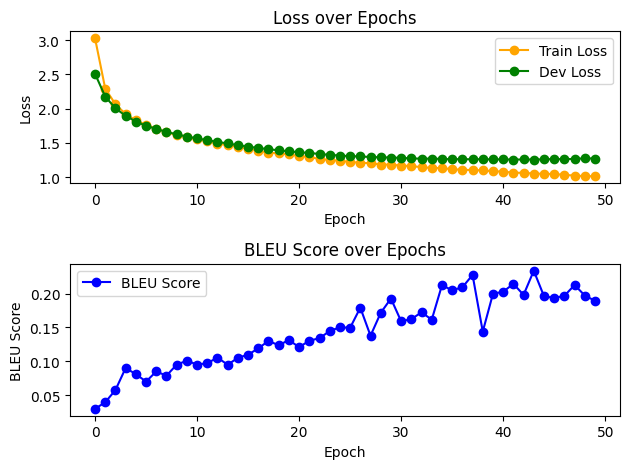

In [ ]:
visualise(train_avg_loss, dev_avg_loss, dev_avg_bleu_score)

From the above graph, we can do the following analysis: when the number of epochs is initially 20, the model can effectively learn the features of the training data, the loss values of both the training and dev sets are decreasing steadily, and the BLEU scores of the dev set are gradually increasing, which indicates that the model has not yet overfitted.

We then increase the training epoch to 30, and the model performs similarly as before, with the BLEU score of the dev set close to saturation, and the difference between the loss in the training and dev sets still small, indicating that the model is close to convergence, but there is only limited room for further training to improve the model.

However, when the epoch is increased to 50, the loss in the dev set slowly rises, and the BLEU score no longer gradually increases, but rather decreases, which indicates that the model is beginning to overfit, i.e., the model has learned too much detail and noise in the training set, but fails to effectively generalize to the dev set.

Therefore, there are still some improvements we can make: introduce early stopping, add regularization (e.g., L2 regularization or Dropout), etc.